In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import covasim as cv
from util import data

sns.set_context('notebook')
sns.set_style('whitegrid')

pop_region = 4.46e6
pop_size = 450e3
pop_scale = 10

cols = ['n_severe', 'n_critical', 'cum_deaths']
n_runs = 3
n_trials = 1000

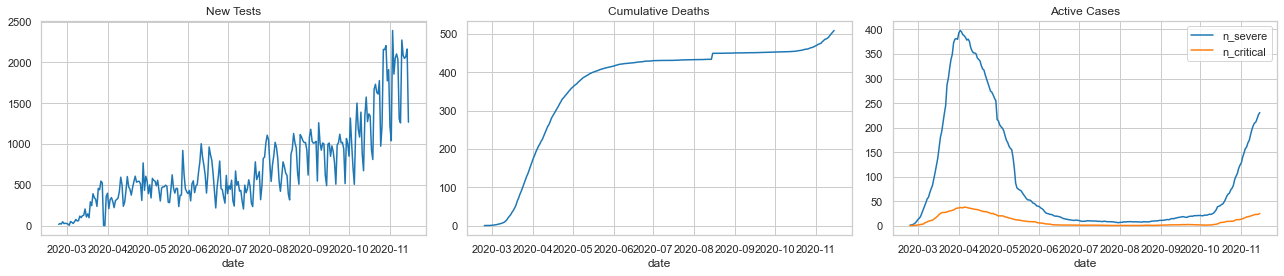

In [ ]:
df = data.get_regional_data(scaling_factor=pop_region/pop_size)
df = df[df['date'] <= pd.to_datetime('2020-11-15')]

_, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=False)

sns.lineplot(data=df, x='date', y='new_tests', ax=axes[0]).set(title='New Tests', ylabel='')
sns.lineplot(data=df, x='date', y='cum_deaths', ax=axes[1]).set(title='Cumulative Deaths', ylabel='')
sns.lineplot(data=df, x='date', y='n_severe', label='n_severe', ax=axes[2]).set(title='Active Cases')
sns.lineplot(data=df, x='date', y='n_critical', label='n_critical', ax=axes[2]).set(ylabel='')

plt.tight_layout()

In [ ]:
default_params = dict(
    pop_type='hybrid',
    location='italy',
    start_day=df['date'].iloc[0],
    end_day=df['date'].iloc[-1],
    pop_size=pop_size / pop_scale,
    pop_scale=pop_scale,
    rescale=True,
    n_beds_hosp=pop_size * 370.4 / 100e3,
    n_beds_icu=pop_size * 14.46 / 100e3,
    quar_period=14,
    verbose=0
)

In [ ]:
from sklearn.metrics import r2_score

def custom_estimator(y_true, y_pred):
    return 1 - r2_score(y_true, y_pred, sample_weight=sample_weight.values)

max_weight = 10

sample_weight = df.set_index(['date'], drop=False)['date']
sample_weight = sample_weight.map(lambda d: (d - pd.to_datetime('2020-09-15').date()).days)
sample_weight = sample_weight.map(lambda d: 1 if d < 0 else 1 + (max_weight - 1) * (d / 61))
sample_weight

date
2020-02-24     1.000000
2020-02-25     1.000000
2020-02-26     1.000000
2020-02-27     1.000000
2020-02-28     1.000000
                ...    
2020-11-11     9.409836
2020-11-12     9.557377
2020-11-13     9.704918
2020-11-14     9.852459
2020-11-15    10.000000
Name: date, Length: 266, dtype: float64

In [ ]:
import optuna as op
from util.interventions import get_interventions

def unused_param(trial, name, value=0.):
    return trial.suggest_float(name, value, value)

def objective(trial):
    # define learnable parameters
    initial_params = dict(
        pop_infected=trial.suggest_int('init_pop_infected', 2400, 4500, step=10),
        n_imports=trial.suggest_float('init_n_imports', 0.6, 2.6, step=1e-1),
        beta=trial.suggest_float('init_beta', 0.018, 0.033, step=1e-3),
        rel_symp_prob=trial.suggest_float('init_rel_symp_prob', 1.8, 10.0, log=True),
        rel_severe_prob=trial.suggest_float('init_rel_severe_prob', 0.05, 0.2, log=True),
        rel_crit_prob=trial.suggest_float('init_rel_crit_prob', 0.7, 1.5, log=True),
        rel_death_prob=trial.suggest_float('init_rel_death_prob', 4.0, 10.0, log=True),
        **default_params
    )
    intervention_params = dict(
        trace_prob=trial.suggest_float('interv_trace_prob', 0.4, 0.85, step=1e-2),          # CONTACT TRACING
        trace_time=trial.suggest_float('interv_trace_time', 2.3, 6.3, step=1e-1),           #
        work_contacts=trial.suggest_float('interv_work_contacts', 0.55, 0.75, step=1e-2),   # SMART WORKING
        school_contacts=trial.suggest_float('interv_school_contacts', 0.0, 1.0, step=1e-2), # SCHOOLS CLOSED
        yellow_contacts=unused_param(trial, 'interv_yellow_contacts'),                      # LOCKDOWN INTERACTIONS
        orange_contacts=unused_param(trial, 'interv_orange_contacts'),                      #
        summer_imports=trial.suggest_float('interv_summer_imp', 0.0, 20.0, step=1e-1),      # IMPORTED CASES
        yellow_imports=unused_param(trial, 'interv_yellow_imp'),                            #
        orange_imports=unused_param(trial, 'interv_orange_imp'),                            #
        summer_beta=trial.suggest_float('interv_summer_beta', 0.0, 0.2, step=1e-3),         # VIRAL LOAD REDUCTION
        winter_beta=trial.suggest_float('interv_winter_beta', 0.0, 0.2, step=1e-3),         #
        summer_symp=trial.suggest_float('interv_summer_symp', 0.01, 10.0, log=True),        #
        winter_symp=trial.suggest_float('interv_winter_symp', 0.01, 10.0, log=True),        #
        summer_sev=trial.suggest_float('interv_summer_sev', 0.01, 10.0, log=True),          #
        winter_sev=trial.suggest_float('interv_winter_sev', 0.01, 10.0, log=True),          #
        summer_crit=trial.suggest_float('interv_summer_crit', 0.01, 10.0, log=True),        #
        winter_crit=trial.suggest_float('interv_winter_crit', 0.01, 10.0, log=True),        #
        summer_death=trial.suggest_float('interv_summer_death', 0.01, 10.0, log=True),      #
        winter_death=trial.suggest_float('interv_winter_death', 0.01, 10.0, log=True)       #
    )
    # define and run simulations
    sim = cv.Sim(pars=initial_params, interventions=get_interventions(intervention_params), datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    # compute loss
    weights = {c: 1 for c in cols}
    mismatches = [s.compute_fit(keys=cols, weights=weights, estimator=custom_estimator).mismatch for s in msim.sims]
    return sum(mismatches) / n_runs

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

[I 2021-03-13 11:30:00,505] A new study created in memory with name: no-name-78fdf8a5-7554-4218-af43-a2debbbd74c7
[I 2021-03-13 11:30:23,282] Trial 0 finished with value: 2833.029592206602 and parameters: {'init_pop_infected': 4130, 'init_n_imports': 1.5, 'init_beta': 0.028999999999999998, 'init_rel_symp_prob': 9.665460587062231, 'init_rel_severe_prob': 0.15058525102534587, 'init_rel_crit_prob': 1.284814334715225, 'init_rel_death_prob': 5.6724195779075295, 'interv_trace_prob': 0.48000000000000004, 'interv_trace_time': 3.4, 'interv_work_contacts': 0.5900000000000001, 'interv_school_contacts': 0.8, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 20.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.028, 'interv_winter_beta': 0.149, 'interv_summer_symp': 6.6251057735439085, 'interv_winter_symp': 0.14237724421662443, 'interv_summer_sev': 0.0340948892796768, 'interv_winter_sev': 4.7935153211462405, 'interv_summer_crit': 0.107859

In [ ]:
best_params = study.best_params
best_params

{'init_pop_infected': 3190,
 'init_n_imports': 2.3000000000000003,
 'init_beta': 0.022,
 'init_rel_symp_prob': 9.8464207861507,
 'init_rel_severe_prob': 0.14307024350007358,
 'init_rel_crit_prob': 1.0290063296151535,
 'init_rel_death_prob': 9.984800462541632,
 'interv_trace_prob': 0.42000000000000004,
 'interv_trace_time': 2.9,
 'interv_work_contacts': 0.68,
 'interv_school_contacts': 0.67,
 'interv_yellow_contacts': 0.0,
 'interv_orange_contacts': 0.0,
 'interv_summer_imp': 5.9,
 'interv_yellow_imp': 0.0,
 'interv_orange_imp': 0.0,
 'interv_summer_beta': 0.035,
 'interv_winter_beta': 0.182,
 'interv_summer_symp': 0.018399111673599384,
 'interv_winter_symp': 2.8993761473214104,
 'interv_summer_sev': 0.18119212274316182,
 'interv_winter_sev': 0.43768043208441476,
 'interv_summer_crit': 0.35539818527656053,
 'interv_winter_crit': 0.2648726423430699,
 'interv_summer_death': 0.025912291481618818,
 'interv_winter_death': 0.42551687385804443}

In [ ]:
results = pd.DataFrame([dict(objective=t.value, **t.params) for t in study.trials])
results = results[results['objective'] <= results['objective'].quantile(0.01)]
results = results.drop('objective', axis=1)
results = results.describe().loc[['count', 'min', 'max']]
results = results.append(pd.Series(best_params, name='best'))
results = results.transpose().astype({'count': 'int'})
results

,count,min,max,best
init_pop_infected,10,3110.000000,3320.000000,3190.000000
init_n_imports,10,0.900000,2.400000,2.300000
init_beta,10,0.021000,0.023000,0.022000
init_rel_symp_prob,10,6.170249,9.983259,9.846421
init_rel_severe_prob,10,0.113250,0.157124,0.143070
init_rel_crit_prob,10,0.834057,1.062751,1.029006
init_rel_death_prob,10,4.688480,9.995094,9.984800
interv_trace_prob,10,0.400000,0.450000,0.420000
interv_trace_time,10,2.600000,3.300000,2.900000
interv_work_contacts,10,0.650000,0.710000,0.680000


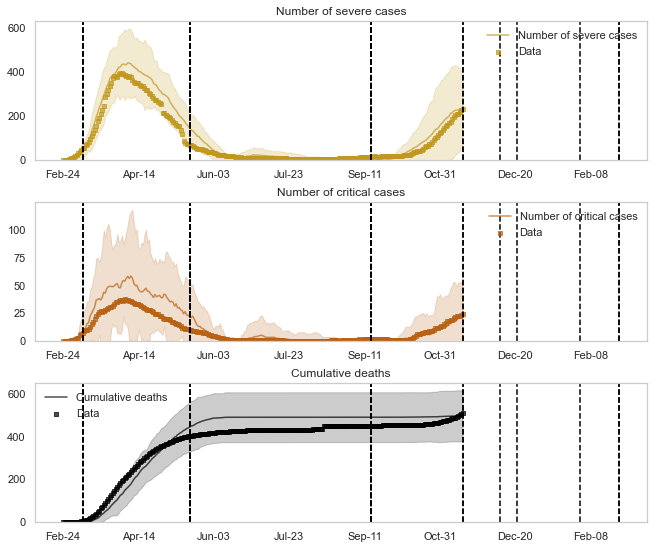

In [ ]:
from util.interventions import get_interventions

initial_params = {k[5:]: v for k, v in best_params.items() if k.startswith('init_')}
initial_params.update(default_params)

intervention_params = {k[7:]: v for k, v in best_params.items() if k.startswith('interv_')}
interventions = get_interventions(intervention_params)

sim = cv.Sim(pars=initial_params, interventions=interventions, datafile=df)
msim = cv.MultiSim(sim)
msim.run(n_runs=30)

msim.mean()
msim.plot(cols);

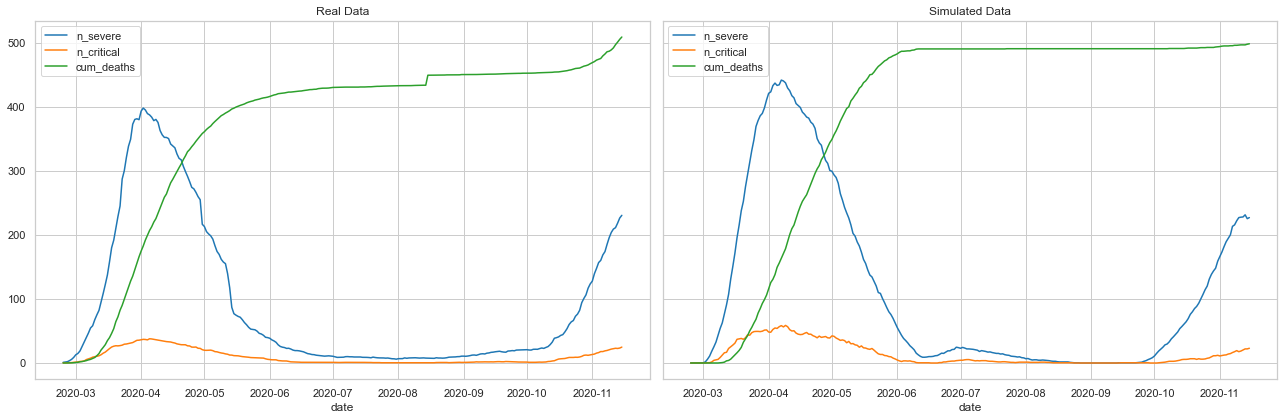

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

for col in cols:
    sns.lineplot(data=df, x='date', y=col, label=col, ax=axes[0]).set(title='Real Data', ylabel='')
    sns.lineplot(data=msim.results, x='date', y=col, label=col, ax=axes[1]).set(title='Simulated Data', ylabel='')

plt.tight_layout()